# Klasyfikatory

### Pakiety

In [1]:
import pandas as pd 
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn import metrics
import random
import warnings 
warnings.filterwarnings('ignore')

In [2]:
from xgboost import XGBClassifier

### Ustawienie ziarna gwarantuje reprodukowalność wyników

In [3]:
np.random.seed(123)

### Wczytanie danych

In [4]:
data = pd.read_csv('australia.csv')
data = pd.DataFrame(data)

### Sprawdzenia zrównoważenia zbioru ze względu na zmienną celu, w celu doboru odpowiednich miar oceny klasyfikacji

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1b6872e10>]],
      dtype=object)

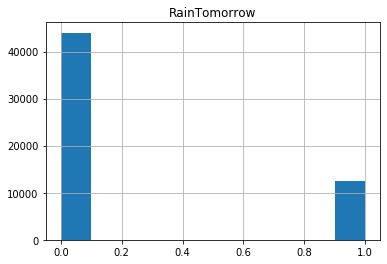

In [5]:
data.filter(["RainTomorrow"]).hist()

Dane są niezrównoważone, więc jako miary jakości klasyfikatora będziemy używać precision i recall (nie accuracy)

# 1. Podział na zbiory treningowy i testowy  

* 80% obserwacji należy do zbioru treningowego, pozostałe do testowego.  
* Odseparowujemy zmienną celu od zmiennych objaśniających.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(data.drop('RainTomorrow', axis=1), data['RainTomorrow'])

# 2. Klasyfikatory

## 2.1. Random Forest

In [7]:
# Stworzenie modelu
rf_classifier = RandomForestClassifier()

# Hiperparametry
param_grid = { 
    'n_estimators': [20, 50, 100, 200],
    'max_features': ['sqrt', 'log2'],  
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

# 'n_estimators' - ilość drzew składowych
# 'max_features' - ilość cech branych pod uwagę podczas poszukiwania najlepszego podziału
        ## jeśli “sqrt”, to max_features=sqrt(n_features)
        ## jeśli “log2”, to max_features=log2(n_features).
# 'max_depth' - maksymalna głębokość drzewa
# 'criterion' - funkcja miary jakości podziału

In [8]:
# Przeszukiwanie optymalnych spośród wyżej podanych wartości parametrów dla estymatora
grid_search1 = GridSearchCV(rf_classifier, param_grid = param_grid, cv = 5)
grid_search1.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [9]:
grid_search1.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 100}

In [10]:
model1 = RandomForestClassifier(criterion='gini', max_depth=8, max_features='log2', n_estimators=100)
model1.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
# Predykcja klasy
predict_class1 = model1.predict(X_test)

# Predykcja prawdopodobieństwa
predict_proba1 = model1.predict_proba(X_test)[:, 1]

## 2.2. XGBoost

In [12]:
# Stworzenie modelu
xgb_classifier = XGBClassifier()

# Hiperparametry
param_grid = {  'booster' : ['gbtree', 'dart', 'gblinear'], # gbtree i dart wykorzystuje modele drzewiaste
                                                            # gblinear - linearne
                'criterion' : ['friedman_mse', 'mse']} # miara jakości podziału 
                                                            ## mse - błąd średniokwadratowy
                                                            ## mae - średni bezwzględny błąd
                                                            ## mse - błąd średniokwadratowy wg Friedmana
            
# Przeszukiwanie optymalnych spośród wyżej podanych wartości parametrów dla estymatora
grid_search2 = GridSearchCV(xgb_classifier, param_grid = param_grid, cv = 5)
grid_search2.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

In [13]:
grid_search2.best_params_

{'booster': 'gbtree', 'criterion': 'friedman_mse'}

In [14]:
model2 = XGBClassifier(booster = 'gbtree', criterion = 'friedman_mse')
model2.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='friedman_mse',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [15]:
# Predykcja klasy
predict_class2 = model2.predict(X_test)

# Predykcja prawdopodobieństwa
predict_proba2 = model2.predict_proba(X_test)[:, 1]

## 2.3. Regresja logistyczna

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
# Model
lr_classifier = LogisticRegression()

# Hiperparametry
param_grid = {'penalty':['l1', 'l2', 'elasticnet', 'none'], # norma kary
              'class_weight':['balanced', None], # balanced - waga klasy odwrotnie proporcjonalna do częstości występowania
                                                # None - każda klasa ma wagę 1 (domyślnie)
              'C': [1, 5, 10] # im mniejsza wartość, tym silniejsza regularyzacja
      }

# Przeszukiwanie optymalnych spośród wyżej podanych wartości parametrów dla estymatora
grid_search3 = GridSearchCV(lr_classifier, param_grid = param_grid, cv = 5)
grid_search3.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [18]:
grid_search3.best_params_

{'C': 5, 'class_weight': None, 'penalty': 'l2'}

In [19]:
model3 = LogisticRegression(C = 5, class_weight=None, penalty='l2')
model3.fit(X_train, Y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
# Predykcja klasy
predict_class3 = model3.predict(X_test)

# Predykcja prawdopodobieństwa
predict_proba3 = model3.predict_proba(X_test)[:, 1]

# Zestawienie rezultatów

## Miary precision i recall
Wartości miary recall na zbiorze testowym dla klasyfikatorów Random Forest, XGBoost i regresji logistycznej wynoszą odpowiednio:


In [21]:
pd.DataFrame({"Metoda" : ["Random Forest", "XGBoost", "Regresja logistyczna"], 
             "Recall" : [recall_score(Y_test, predict_class1), recall_score(Y_test, predict_class2), recall_score(Y_test, predict_class3)],
             "Precision" : [precision_score(Y_test, predict_class1, average='macro'), precision_score(Y_test, predict_class2, average='macro'), precision_score(Y_test, predict_class3, average='macro')]})

,Metoda,Recall,Precision
0,Random Forest,0.469467,0.823328
1,XGBoost,0.547658,0.808522
2,Regresja logistyczna,0.523425,0.801628


## Krzywe Precision-Recall

Text(0.5, 1.0, 'Krzywa Precision-Recall dla regresji logistycznej')

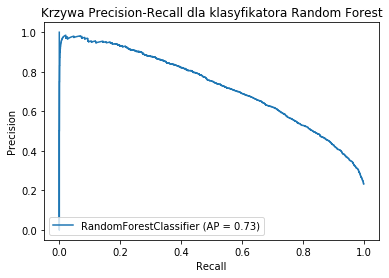

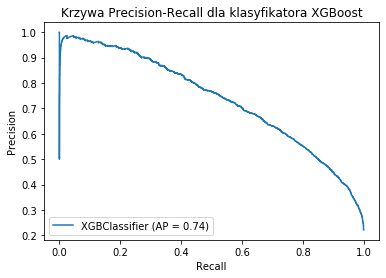

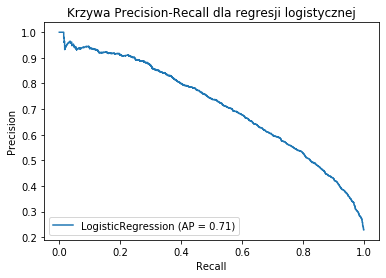

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp1 = plot_precision_recall_curve(model1, X_test, Y_test)
disp1.ax_.set_title('Krzywa Precision-Recall dla klasyfikatora Random Forest')
disp2 = plot_precision_recall_curve(model2, X_test, Y_test)
disp2.ax_.set_title('Krzywa Precision-Recall dla klasyfikatora XGBoost')
disp3 = plot_precision_recall_curve(model3, X_test, Y_test)
disp3.ax_.set_title('Krzywa Precision-Recall dla regresji logistycznej')


## Krzywa ROCR i miara AUC

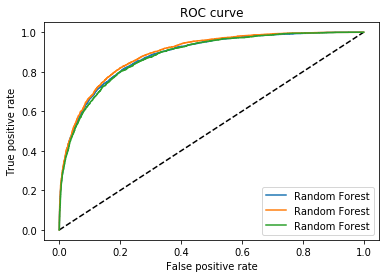

In [23]:
# Krzywa ROCR
fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_test, predict_proba1) # false & true positive rates
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_test, predict_proba2) # false & true positive rates
fpr3, tpr3, thresholds3 = metrics.roc_curve(Y_test, predict_proba3) # false & true positive rates

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='Random Forest')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [24]:
# Miara AUC
pd.DataFrame({"Klasyfikator" : ["Random Forest", "XGBoost", "Regresja Logistyczna"],
             "AUC": [metrics.auc(fpr1, tpr1), metrics.auc(fpr2, tpr2), metrics.auc(fpr3, tpr3)]})

,Klasyfikator,AUC
0,Random Forest,0.885704
1,XGBoost,0.893298
2,Regresja Logistyczna,0.881957


## Wnioski

# Regresja liniowa

In [25]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### Wczytanie danych

In [26]:
df = pd.read_csv('allegro-api-transactions.csv')
df = pd.DataFrame(df)
df = df.drop(['lp', 'date'], axis = 1)

Y = df.price

Wybór metod wynika z faktu, że na pierwszy rzut oka wydają się one bardzo podobne. Celem poniższych rozważań jest weryfikacja, czy model nauczony na 3 podobnych typach encodingu, będzie ze zbliżoną dokładnością przewidywał ceny produktu.

## 1. Target Encoding

In [27]:
te = ce.TargetEncoder(cols = ['categories', 'seller','it_location', 'main_category'])
encoded1 = te.fit_transform(df, Y)
encoded1.head()

,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,4753602474,61.839771,1,1,44.512149,59.99,1,997,0,50177,85.423398,121.810064
1,4773181874,12.375798,1,1,7.868889,4.90,1,9288,0,12428,85.423398,75.858049
2,4781627074,105.272597,1,1,132.503382,109.90,1,895,0,7389,61.990914,72.434754
3,4783971474,24.072564,1,1,25.027386,18.50,0,971,0,15006,35.433365,25.027497
4,4787908274,17.102344,1,1,10.121538,19.90,1,950,0,32975,117.191956,75.858049


In [28]:
# Podział na zbiory treningowy i testowy
train_X1, test_X1, train_Y1, test_Y1 = train_test_split(encoded1.drop('price', axis=1), encoded1['price'])

# Model
linreg1 = LinearRegression()
linreg1.fit(train_X1, train_Y1)

# Predykcja
y_pred1 = linreg1.predict(test_X1)

## 2. James Stein Encoding

In [29]:
js = ce.james_stein.JamesSteinEncoder(df, cols = ['categories', 'seller','it_location', 'main_category'])
encoded2 = js.fit_transform(df, Y)
encoded2.head()

,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,4753602474,62.074264,1,1,44.944658,59.99,1,997,0,50177,79.839317,101.735793
1,4773181874,12.438550,1,1,7.897045,4.90,1,9288,0,12428,79.839317,75.894257
2,4781627074,104.607200,1,1,131.180169,109.90,1,895,0,7389,63.839460,73.179117
3,4783971474,24.127684,1,1,25.056512,18.50,0,971,0,15006,36.283195,25.346202
4,4787908274,17.326369,1,1,10.200595,19.90,1,950,0,32975,105.860840,75.894257


In [30]:
# Podział na zbiory treningowy i testowy
train_X2, test_X2, train_Y2, test_Y2 = train_test_split(encoded2.drop('price', axis=1), encoded2['price'])

# Model
linreg2 = LinearRegression()
linreg2.fit(train_X2, train_Y2)

# Predykcja
y_pred2 = linreg2.predict(test_X2)

## 3. CatBoost Encoding

In [31]:
cb = ce.CatBoostEncoder(cols = ['categories', 'seller','it_location', 'main_category'])

df2 = df.copy()
Y2 = Y.copy()

# Losowa permutacja wierszy (zabieg zalecane w dokumentacji)

permutation = np.random.permutation(len(df2)) 
df2 = df2.iloc[permutation].reset_index(drop = True)
Y2 = Y2.iloc[permutation].reset_index(drop = True)

encoded3 = cb.fit_transform(df2, Y2)

In [32]:
# Podział na zbiory treningowy i testowy
train_X3, test_X3, train_Y3, test_Y3 = train_test_split(encoded3.drop('price', axis=1), encoded3['price'])

# Model
linreg3 = LinearRegression()
linreg3.fit(train_X3, train_Y3)

# Predykcja
y_pred3 = linreg3.predict(test_X3)

## Zestawienie wyników

In [33]:
pd.DataFrame({"Metoda" : ["Target Encoding", "James Stein Encoding", "Regresja liniowa"], 
             "R2" : [r2_score(test_Y1, y_pred1), r2_score(test_Y2, y_pred2), r2_score(test_Y3, y_pred3)],
             "RMSE" : [mean_squared_error(test_Y1, y_pred1, squared=False), mean_squared_error(test_Y2, y_pred2, squared=False), mean_squared_error(test_Y3, y_pred3, squared=False)]})

,Metoda,R2,RMSE
0,Target Encoding,0.139989,463.537185
1,James Stein Encoding,0.778943,124.146830
2,Regresja liniowa,0.221863,251.854794


## Wnioski